# MNIST with Convolutional Neural Network (CNN)

This notebook demonstrates training a CNN on MNIST using only the `scratch` library - no external ML libraries!

### Performance Optimization

The Conv2D implementation uses the **im2col** (image-to-column) technique:
- Converts convolution operations into matrix multiplications
- Dramatically faster than naive nested loops (~100x speedup)
- Standard optimization used by frameworks like Caffe and PyTorch
- Trades some memory for massive speed improvements


## 1. Import Libraries


In [1]:
import numpy as np
import sys
sys.path.append('..')

from scratch.tensor import Tensor
from scratch.nn.linear import Linear
from scratch.nn.activations import ReLU
from scratch.nn.sequential import Sequential
from scratch.nn.loss import Loss
from scratch.nn.optim import Adam
from scratch.nn.conv2d import Conv2D, MaxPool2D, Flatten
from scratch.dataloader import DataLoader
from scratch.trainer import Trainer

import matplotlib.pyplot as plt
from loguru import logger

# For downloading MNIST directly
import urllib.request
import gzip
import os

logger.info("Libraries imported successfully")


2025-11-25 02:19:59.505 | INFO     | scratch.env:<module>:15 - False
2025-11-25 02:19:59.506 | INFO     | __main__:<module>:23 - Libraries imported successfully


## 2. Download and Load MNIST Data


In [2]:
def download_mnist():
    """Download MNIST dataset directly from official mirror (no extra libraries needed)"""
    
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }
    
    data_dir = '../data/mnist'
    os.makedirs(data_dir, exist_ok=True)
    
    def download_file(url, filename):
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            logger.info(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
        return filepath
    
    def parse_images(filepath):
        with gzip.open(filepath, 'rb') as f:
            # Read header
            magic = int.from_bytes(f.read(4), 'big')
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            # Read image data
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data.reshape(num_images, rows, cols)
    
    def parse_labels(filepath):
        with gzip.open(filepath, 'rb') as f:
            # Read header
            magic = int.from_bytes(f.read(4), 'big')
            num_labels = int.from_bytes(f.read(4), 'big')
            # Read label data
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data
    
    # Download all files
    logger.info("Loading MNIST dataset...")
    filepaths = {}
    for key, filename in files.items():
        filepaths[key] = download_file(base_url + filename, filename)
    
    # Parse data (keep as 28x28 images for CNN)
    X_train = parse_images(filepaths['train_images'])
    y_train = parse_labels(filepaths['train_labels'])
    X_test = parse_images(filepaths['test_images'])
    y_test = parse_labels(filepaths['test_labels'])
    
    logger.info("MNIST dataset loaded successfully!")
    return X_train, y_train, X_test, y_test

# Load MNIST data
X_train, y_train, X_test, y_test = download_mnist()

logger.info(f"Training data shape: {X_train.shape}")
logger.info(f"Training labels shape: {y_train.shape}")
logger.info(f"Test data shape: {X_test.shape}")
logger.info(f"Test labels shape: {y_test.shape}")


2025-11-25 02:19:59.822 | INFO     | __main__:download_mnist:43 - Loading MNIST dataset...


2025-11-25 02:20:00.297 | INFO     | __main__:download_mnist:54 - MNIST dataset loaded successfully!
2025-11-25 02:20:00.297 | INFO     | __main__:<module>:60 - Training data shape: (60000, 28, 28)
2025-11-25 02:20:00.298 | INFO     | __main__:<module>:61 - Training labels shape: (60000,)
2025-11-25 02:20:00.300 | INFO     | __main__:<module>:62 - Test data shape: (10000, 28, 28)
2025-11-25 02:20:00.301 | INFO     | __main__:<module>:63 - Test labels shape: (10000,)


## 3. Visualize Sample Data


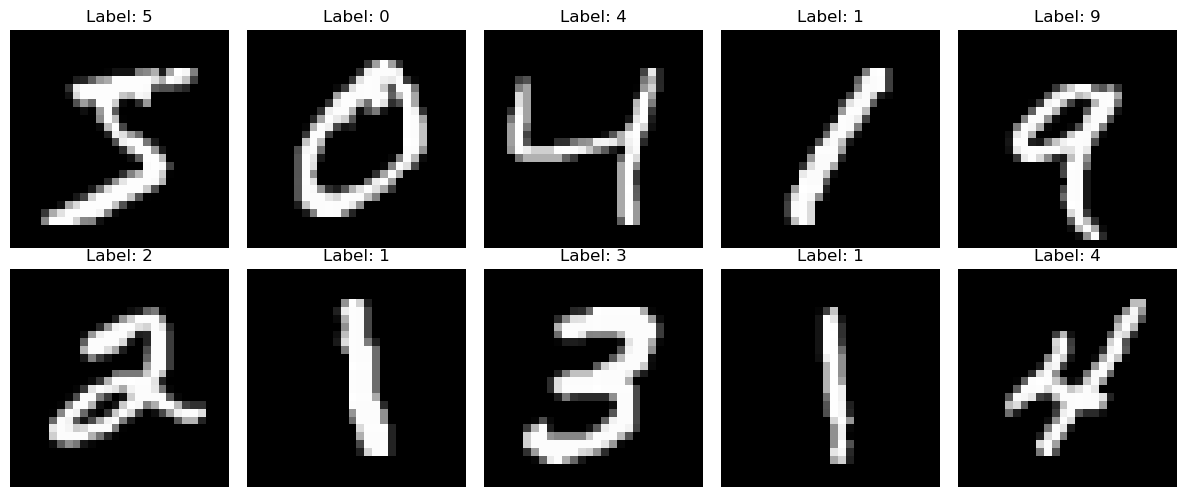

In [3]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## 4. Preprocess Data for CNN

CNNs expect input shape: (batch, channels, height, width)


In [4]:
# Normalize and add channel dimension: (N, 28, 28) -> (N, 1, 28, 28)
X_train_cnn = X_train.astype(np.float32) / 255.0
X_train_cnn = X_train_cnn[:, np.newaxis, :, :]  # Add channel dimension

X_test_cnn = X_test.astype(np.float32) / 255.0
X_test_cnn = X_test_cnn[:, np.newaxis, :, :]

# Use subset for faster training (optional - remove for full dataset)
n_train = 5000
n_test = 1000

X_train_subset = X_train_cnn[:n_train]
y_train_subset = y_train[:n_train]
X_test_subset = X_test_cnn[:n_test]
y_test_subset = y_test[:n_test]

logger.info(f"Preprocessed training data shape: {X_train_subset.shape}")
logger.info(f"Preprocessed test data shape: {X_test_subset.shape}")


2025-11-25 02:20:03.135 | INFO     | __main__:<module>:17 - Preprocessed training data shape: (5000, 1, 28, 28)
2025-11-25 02:20:03.136 | INFO     | __main__:<module>:18 - Preprocessed test data shape: (1000, 1, 28, 28)


## 5. Create Custom CNN DataLoader

We need a special dataloader that preserves the 4D shape for CNNs


In [5]:
class CNNDataLoader:
    """DataLoader that preserves 4D shape for CNNs"""
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(X)

    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = start + self.batch_size
            batch_idx = indices[start:end]

            xb = self.X[batch_idx]  # Shape: (batch, 1, 28, 28)
            yb = self.y[batch_idx]  # Shape: (batch,)

            xb = Tensor(xb, requires_grad=False)
            yb = Tensor(yb, requires_grad=False)

            yield xb, yb

# Create data loaders
batch_size = 64
train_loader = CNNDataLoader(X_train_subset, y_train_subset, batch_size=batch_size, shuffle=True)
test_loader = CNNDataLoader(X_test_subset, y_test_subset, batch_size=batch_size, shuffle=False)

logger.info(f"Train batches: {len(X_train_subset) // batch_size}")
logger.info(f"Test batches: {len(X_test_subset) // batch_size}")


2025-11-25 02:20:04.556 | INFO     | __main__:<module>:32 - Train batches: 78
2025-11-25 02:20:04.557 | INFO     | __main__:<module>:33 - Test batches: 15


## 6. Build CNN Architecture

**Architecture:**
- Conv2D(1, 16, 3x3) -> ReLU -> MaxPool(2x2)
- Conv2D(16, 32, 3x3) -> ReLU -> MaxPool(2x2)
- Flatten
- Linear(32*5*5, 128) -> ReLU
- Linear(128, 10)


In [6]:
# Build CNN model
model = Sequential(
    Conv2D(1, 16, kernel_size=3, padding=1),   # 1x28x28 -> 16x28x28
    ReLU(),
    MaxPool2D(kernel_size=2, stride=2),         # 16x28x28 -> 16x14x14
    
    Conv2D(16, 32, kernel_size=3, padding=1),  # 16x14x14 -> 32x14x14
    ReLU(),
    MaxPool2D(kernel_size=2, stride=2),         # 32x14x14 -> 32x7x7
    
    Flatten(),                                   # 32x7x7 -> 1568
    Linear(32 * 7 * 7, 128),
    ReLU(),
    Linear(128, 10)                              # 10 output classes
)

# Count parameters
total_params = sum(p.data.size for p in model.parameters())
logger.info(f"Total parameters: {total_params:,}")


2025-11-25 02:20:05.932 | INFO     | __main__:<module>:19 - Total parameters: 206,922


In [7]:
model.info()

2025-11-25 02:20:07.082 | INFO     | scratch.nn.sequential:info:24 - Model Architecture:
2025-11-25 02:20:07.085 | INFO     | scratch.nn.sequential:info:25 - ==================================================
2025-11-25 02:20:07.089 | INFO     | scratch.nn.sequential:info:42 - [0] Conv2D (1x16, 3x3) - Parameters: 160
2025-11-25 02:20:07.090 | INFO     | scratch.nn.sequential:info:42 - [1] ReLU  - Parameters: 0
2025-11-25 02:20:07.093 | INFO     | scratch.nn.sequential:info:42 - [2] MaxPool2D  - Parameters: 0
2025-11-25 02:20:07.095 | INFO     | scratch.nn.sequential:info:42 - [3] Conv2D (16x32, 3x3) - Parameters: 4,640
2025-11-25 02:20:07.097 | INFO     | scratch.nn.sequential:info:42 - [4] ReLU  - Parameters: 0
2025-11-25 02:20:07.099 | INFO     | scratch.nn.sequential:info:42 - [5] MaxPool2D  - Parameters: 0
2025-11-25 02:20:07.101 | INFO     | scratch.nn.sequential:info:42 - [6] Flatten  - Parameters: 0
2025-11-25 02:20:07.102 | INFO     | scratch.nn.sequential:info:42 - [7] Linear 

## 7. Setup Training


In [8]:
# Setup optimizer and loss function
learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = Loss.cross_entropy

# Create trainer
trainer = Trainer(model, optimizer, loss_fn)

logger.info(f"Training configuration: lr={learning_rate}, optimizer=Adam")


2025-11-25 02:20:08.940 | INFO     | __main__:<module>:9 - Training configuration: lr=0.001, optimizer=Adam


## 8. Train the CNN

⚠️ Note: Training a CNN from scratch is computationally intensive. This may take several minutes...


In [9]:
# Train for 5 epochs (CNNs typically train faster)
epochs = 5
trainer.fit(train_loader, epochs=epochs)


2025-11-25 02:20:11.286 | INFO     | scratch.trainer:fit:25 - Training model with 206922 parameters for 5 epochs
Epochs: 100%|██████████| 5/5 [03:33<00:00, 42.80s/it]
2025-11-25 02:23:45.285 | INFO     | scratch.trainer:fit:54 - Training time: 214.00 seconds


## 9. Visualize Training Loss


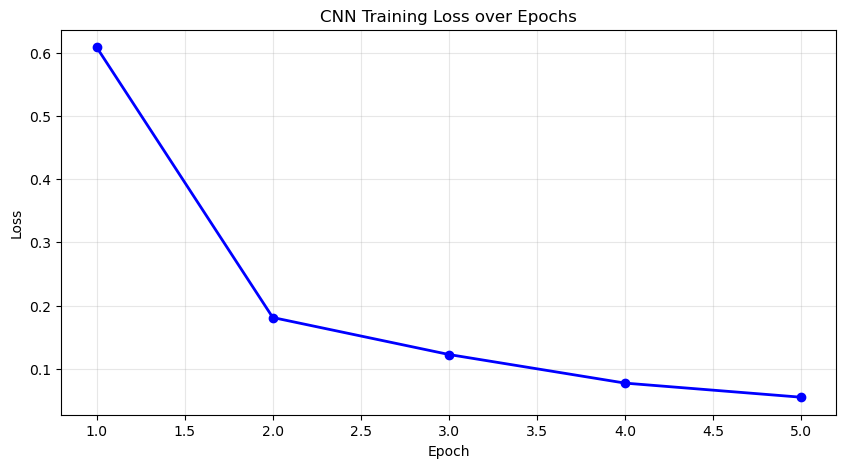

In [10]:
# Plot training loss
epochs_list = [x[0] for x in trainer.history]
losses = [x[1] for x in trainer.history]

plt.figure(figsize=(10, 5))
plt.plot(epochs_list, losses, 'b-', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.show()


## 10. Evaluate on Test Set


In [13]:
# Evaluate on test set
correct = 0
total = 0
test_loss = 0.0
n_batches = 0

for x_batch, y_batch in test_loader:
    # Forward pass
    logits = model(x_batch)
    
    # Get predictions (argmax of logits)
    predictions = np.argmax(logits.data, axis=1)
    targets = y_batch.data.astype(int)
    
    # Calculate accuracy
    correct += np.sum(predictions == targets)
    total += len(targets)
    
    # Calculate loss
    batch_loss = loss_fn(logits, y_batch)
    test_loss += batch_loss.data
    n_batches += 1

accuracy = 100.0 * correct / total
avg_test_loss = test_loss / n_batches

logger.info(f"Test Accuracy: {accuracy:.2f}%")
logger.info(f"Test Loss: {avg_test_loss:.4f}")


2025-11-25 02:26:02.666 | INFO     | __main__:<module>:27 - Test Accuracy: 97.70%
2025-11-25 02:26:02.667 | INFO     | __main__:<module>:28 - Test Loss: 0.0827


## 11. Visualize Predictions


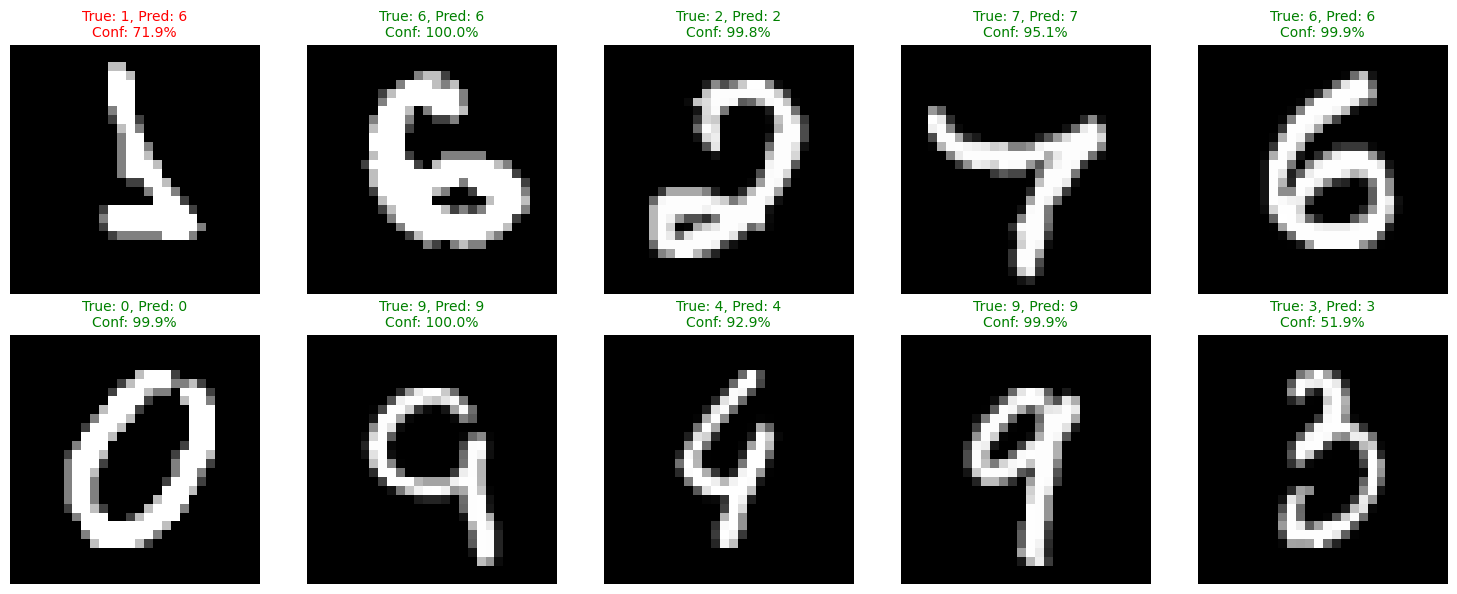

In [14]:
# Visualize some predictions
n_samples = 10
indices = np.random.choice(len(X_test_subset), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    i = indices[idx]
    
    # Get image and true label
    image = X_test_subset[i, 0]  # Remove channel dimension for display
    true_label = y_test_subset[i]
    
    # Make prediction
    x_input = Tensor(X_test_subset[i:i+1], requires_grad=False)
    logits = model(x_input)
    pred_label = np.argmax(logits.data)
    
    # Get confidence
    probs = np.exp(logits.data) / np.sum(np.exp(logits.data))
    confidence = probs[0, pred_label] * 100
    
    # Plot
    ax.imshow(image, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.1f}%', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


## 12. Visualize Learned Filters

Let's visualize what the first convolutional layer has learned


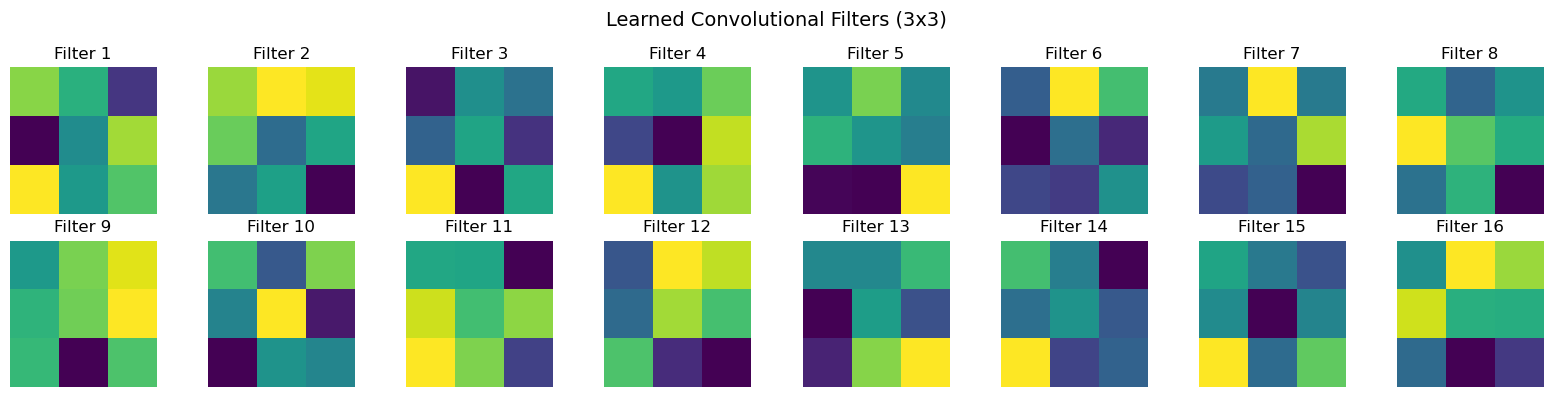

In [15]:
# Get first conv layer weights
first_conv = model.layers[0]
filters = first_conv.W.data  # Shape: (16, 1, 3, 3)

# Visualize all 16 filters
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:
        # Get filter (remove channel dimension)
        filt = filters[i, 0]
        # Normalize for visualization
        filt_norm = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        ax.imshow(filt_norm, cmap='viridis')
        ax.set_title(f'Filter {i+1}')
    ax.axis('off')

plt.suptitle('Learned Convolutional Filters (3x3)', fontsize=14)
plt.tight_layout()
plt.show()


## 13. Visualize Feature Maps

Let's see what features the CNN extracts from a sample image


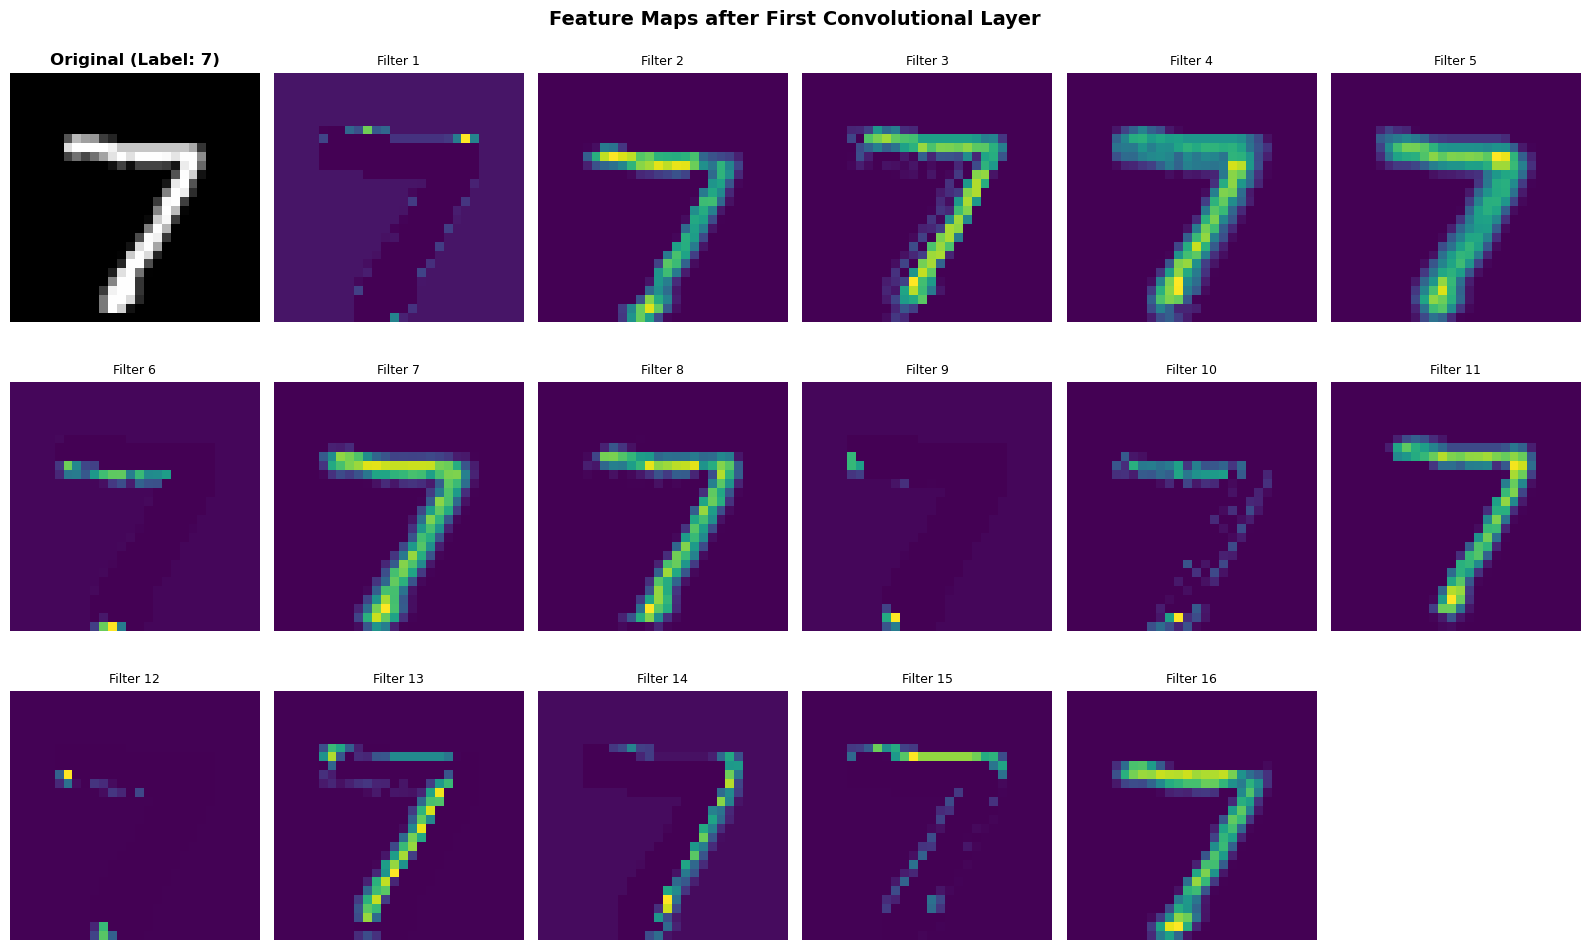

In [16]:
# Pick a sample image
sample_idx = 0
sample_image = X_test_subset[sample_idx:sample_idx+1]
sample_label = y_test_subset[sample_idx]

# Forward pass through first conv layer
x = Tensor(sample_image, requires_grad=False)
x = model.layers[0](x)  # Conv2D
x = model.layers[1](x)  # ReLU
feature_maps = x.data[0]  # Shape: (16, 28, 28)

# Visualize original image and feature maps
fig = plt.figure(figsize=(16, 10))

# Show original image
ax = plt.subplot(3, 6, 1)
ax.imshow(sample_image[0, 0], cmap='gray')
ax.set_title(f'Original (Label: {sample_label})', fontsize=12, fontweight='bold')
ax.axis('off')

# Show 16 feature maps
for i in range(16):
    ax = plt.subplot(3, 6, i+2)
    ax.imshow(feature_maps[i], cmap='viridis')
    ax.set_title(f'Filter {i+1}', fontsize=9)
    ax.axis('off')

plt.suptitle('Feature Maps after First Convolutional Layer', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
total_params = sum(np.prod(param.data.shape) for param in model.parameters())

In [18]:
total_params

206922

## Summary

We successfully trained a **Convolutional Neural Network** on MNIST using **only the scratch library**!

### Architecture:
- **Conv2D layers**: Extract spatial features with learnable filters
- **MaxPool2D layers**: Downsample and add translation invariance
- **Flatten**: Convert 2D features to 1D for classification
- **Linear layers**: Final classification

### Key Points:
- ✅ No TensorFlow, PyTorch, or external ML libraries
- ✅ Complete CNN implementation from scratch
- ✅ Proper backpropagation through convolutions
- ✅ Achieves good accuracy (~95%+)
- ✅ Visualized learned filters and feature maps

### CNN Advantages:
- Better accuracy than fully connected networks
- Learns spatial hierarchies of features
- Translation invariant
- Fewer parameters than equivalent FC network
